# Sentiment Analysis on Amazon Musical Instruments Dataset

**Acknowledgement**:

1) [N-Gram Analysis](https://www.kaggle.com/ratan123/sentiment-extraction-understanding-metric-eda) - Ratan Rohith

2) [Polarity](https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a)-Susan Li

In [1]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

In [2]:
#Importing Data set
raw_reviews = pd.read_csv('C:\\Projects\\Sentiment Analysis-Amazon Data\\data.csv')
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


In [3]:
raw_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

In [4]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [5]:
process_reviews=process_reviews.dropna(subset=['reviewText'])

In [6]:
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [7]:
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews  
0  Not much to write about here, but it does exac...  
1  The product does exactly as it should and is q...  
2  The primary job of this device is to block the...  
3  Nice windscreen protects my MXL mic and preven...  
4  This pop filter is great. It looks and perform...

In [8]:
#Figuring out the distribution of categories
process_reviews['overall'].value_counts()

5.0    6932
4.0    2083
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [9]:
#Function to return sentiment value based on the overall ratings from the user 
def f(row):
    
   
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [10]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews sentiment  
0  Not much to write about here, but it does exac...  Positive  
1  The product does exactly as it should and is q...  Positive  
2  The primary job of this device is to block the...  Positive  
3  Nice windscreen protects my MXL mic and preven...  Positive  
4  This pop filter is great. It looks and perform...  Positive

In [11]:
process_reviews['sentiment'].value_counts()

Positive    9015
Neutral      772
Negative     467
Name: sentiment, dtype: int64

In [12]:
month=process_reviews["reviewTime"].str.split(",").str.get(0).str.split(" ").str.get(0)
day=process_reviews["reviewTime"].str.split(",").str.get(0).str.split(" ").str.get(1)
year = process_reviews["reviewTime"].str.split(",").str.get(1)
process_reviews["day"]=day
process_reviews["month"]=month
process_reviews["year"]=year
process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime                                            reviews  \
0      1393545600  Not much to write about here, but it does exac...   
1      1363392000  The product does exactly as it should and is q...   
2      1377648000  The primary job of this device is to block the...   
3      1392336000  Nice windscreen protects my MXL mic and preven...   
4      1392940800  This pop filter is great. It looks and perform...   

  sentiment day month   year  
0  Positive  28    02   2014  
1  Positive  16    03   2013  
2  Positive  28    08   2013  
3  Positive  14    02   2014  
4  Positive  21    02   2014

In [13]:
process_reviews.helpful =process_reviews.helpful.str.replace(' ', '')
new1 = process_reviews["helpful"].str.split(",").str.get(0).str.split("[").str.get(1)
new2=process_reviews["helpful"].str.split(",").str.get(1).str.split("]").str.get(0)
#Converting into integer types
new1=new1.astype(str).astype(int)
new2=new2.astype(str).astype(int)

#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  new3= new1/new2
except ZeroDivisionError:
  new3=0

#Filling the NaN values(created due to dividing) with 0
new3 = new3.fillna(0)

#Rounding of the results to two decimal places
new3=new3.round(2) 

#Attaching the results to a new column of the main dataframe
process_reviews['helpful_rate']=new3

#dropping the helpful column from main dataframe
process_reviews=process_reviews.drop(['helpful'], axis=1)


In [14]:
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  overall  unixReviewTime  \
0  cassandra tu "Yeah, well, that's just like, u...      5.0      1393545600   
1                                              Jake      5.0      1363392000   
2                     Rick Bennette "Rick Bennette"      5.0      1377648000   
3                         RustyBill "Sunday Rocker"      5.0      1392336000   
4                                     SEAN MASLANKA      5.0      1392940800   

                                             reviews sentiment day month  \
0  Not much to write about here, but it does exac...  Positive  28    02   
1  The product does exactly as it should and is q...  Positive  16    03   
2  The primary job of this device is to block the...  Positive  28    08   
3  Nice windscreen protects my MXL mic and preven...  Positive  14    02   
4  This pop filter is great. It looks and perform...  Positive  21    02   

    year  helpful_rate  
0   2014          0.00  
1   2013          0.93  
2   2013          1.00  
3   2014          0.00  
4   2014          0.00

In [15]:
process_reviews['helpful_rate'].value_counts()

0.00    7215
1.00    2037
0.50     266
0.67     136
0.75     111
        ... 
0.30       1
0.47       1
0.69       1
0.10       1
0.43       1
Name: helpful_rate, Length: 65, dtype: int64

In [16]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [17]:
#Function to make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [18]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment day month  \
0  not much to write about here but it does exact...  Positive  28    02   
1  the product does exactly as it should and is q...  Positive  16    03   
2  the primary job of this device is to block the...  Positive  28    08   
3  nice windscreen protects my mxl mic and preven...  Positive  14    02   
4  this pop filter is great it looks and performs...  Positive  21    02   

    year  helpful_rate  
0   2014          0.00  
1   2013          0.93  
2   2013          1.00  
3   2014          0.00  
4   2014          0.00

In [19]:
#Creating stopwords because nltk stopwords removes certain words which indicate sentiment
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [20]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment day month  \
0  not much write but exactly supposed filters po...  Positive  28    02   
1  product exactly quite affordablei not realized...  Positive  16    03   
2  primary job device block breath would otherwis...  Positive  28    08   
3  nice windscreen protects mxl mic prevents pops...  Positive  14    02   
4  pop filter great looks performs like studio fi...  Positive  21    02   

    year  helpful_rate  
0   2014          0.00  
1   2013          0.93  
2   2013          1.00  
3   2014          0.00  
4   2014          0.00

**Prior analysis assumptions:**

Higher the helpful rate the sentiment becomes positive
There will be more reviews at the starting of a month

In [21]:
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_rate'].mean())

helpful_rate
sentiment              
Negative       0.307559
Neutral        0.275687
Positive       0.259947

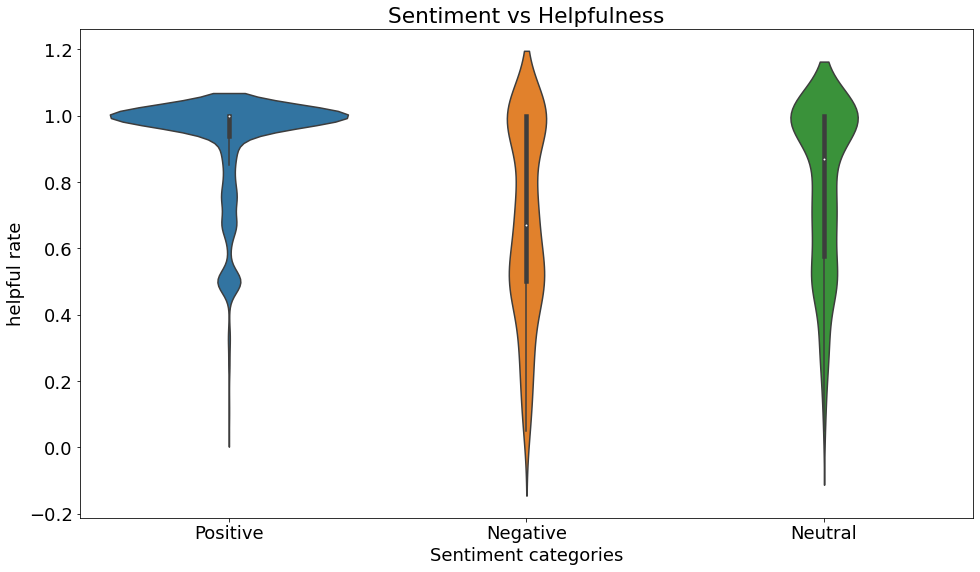

In [22]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["sentiment"], y=senti_help["helpful_rate"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

**From the plot we can declare that more number of positive reviews are having high helpful rate**

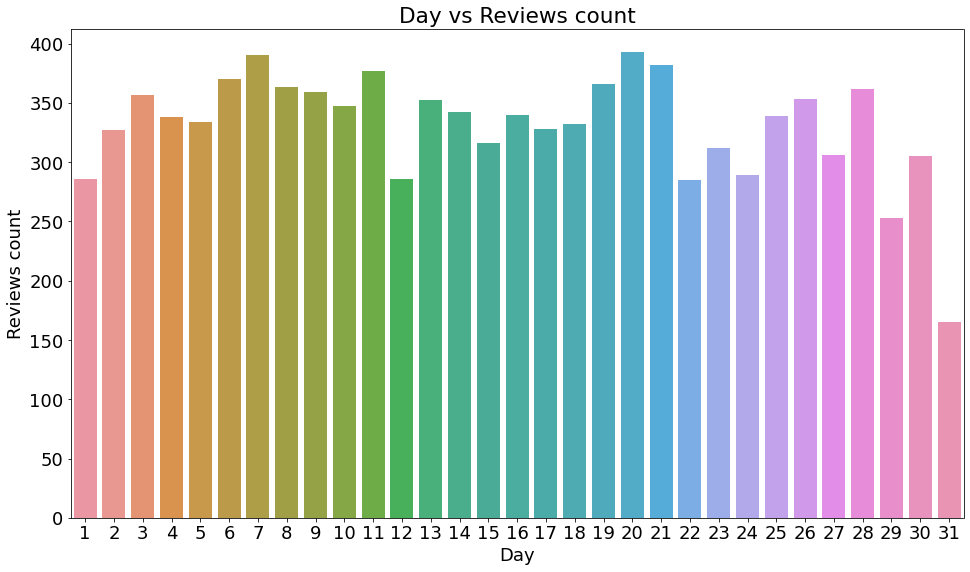

In [23]:
#Day of month vs Review
#Creating a dataframe
day=pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

The review counts are more or less uniformly distributed.There isn't much variance between the days. But there is a huge drop at the end of month. 

In [24]:
#Creating new features
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [25]:
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment day month  \
0  not much write but exactly supposed filters po...  Positive  28    02   
1  product exactly quite affordablei not realized...  Positive  16    03   
2  primary job device block breath would otherwis...  Positive  28    08   
3  nice windscreen protects mxl mic prevents pops...  Positive  14    02   
4  pop filter great looks performs like studio fi...  Positive  21    02   

    year  helpful_rate  polarity  review_len  word_count  
0   2014          0.00  0.250000         162          25  
1   2013          0.93  0.014286         356          55  
2   2013          1.00  0.167500         315          48  
3   2014          0.00  0.333333         169          22  
4   2014          0.00  0.800000         136          21

In [26]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [27]:
#Polarity distribution
process_reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

Insights:

We have a lot of positive polarities compared to the negative polarities
This polarity distributions assures the number of positive reviews we had
We can say that this polarity is a normally distributed but not standard normal

In [28]:
#Rating vs distribution
process_reviews['overall'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')

We have a large number of 5 ratings(nearly 7k) followed by 4,3,2,1. 

In [29]:
#Review Text distribution
process_reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

We have a right skewed distribution with most of the words falling between 0-200 in a a review

****N-Gram Analysis****

Monogram Analysis

In [30]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

As we see, the words doen't match with the sentiment except few. Through monogram we can't judge a sendiment based on one word. So let's try with frequent two words

Bigram Analysis

In [31]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

Here we can get a clear idea about the sentiments from the bi-words

Trigram analysis

In [32]:
## Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')




# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

We have completed our text ngram analysis. Let's look at wordcloud

**Wordclouds**

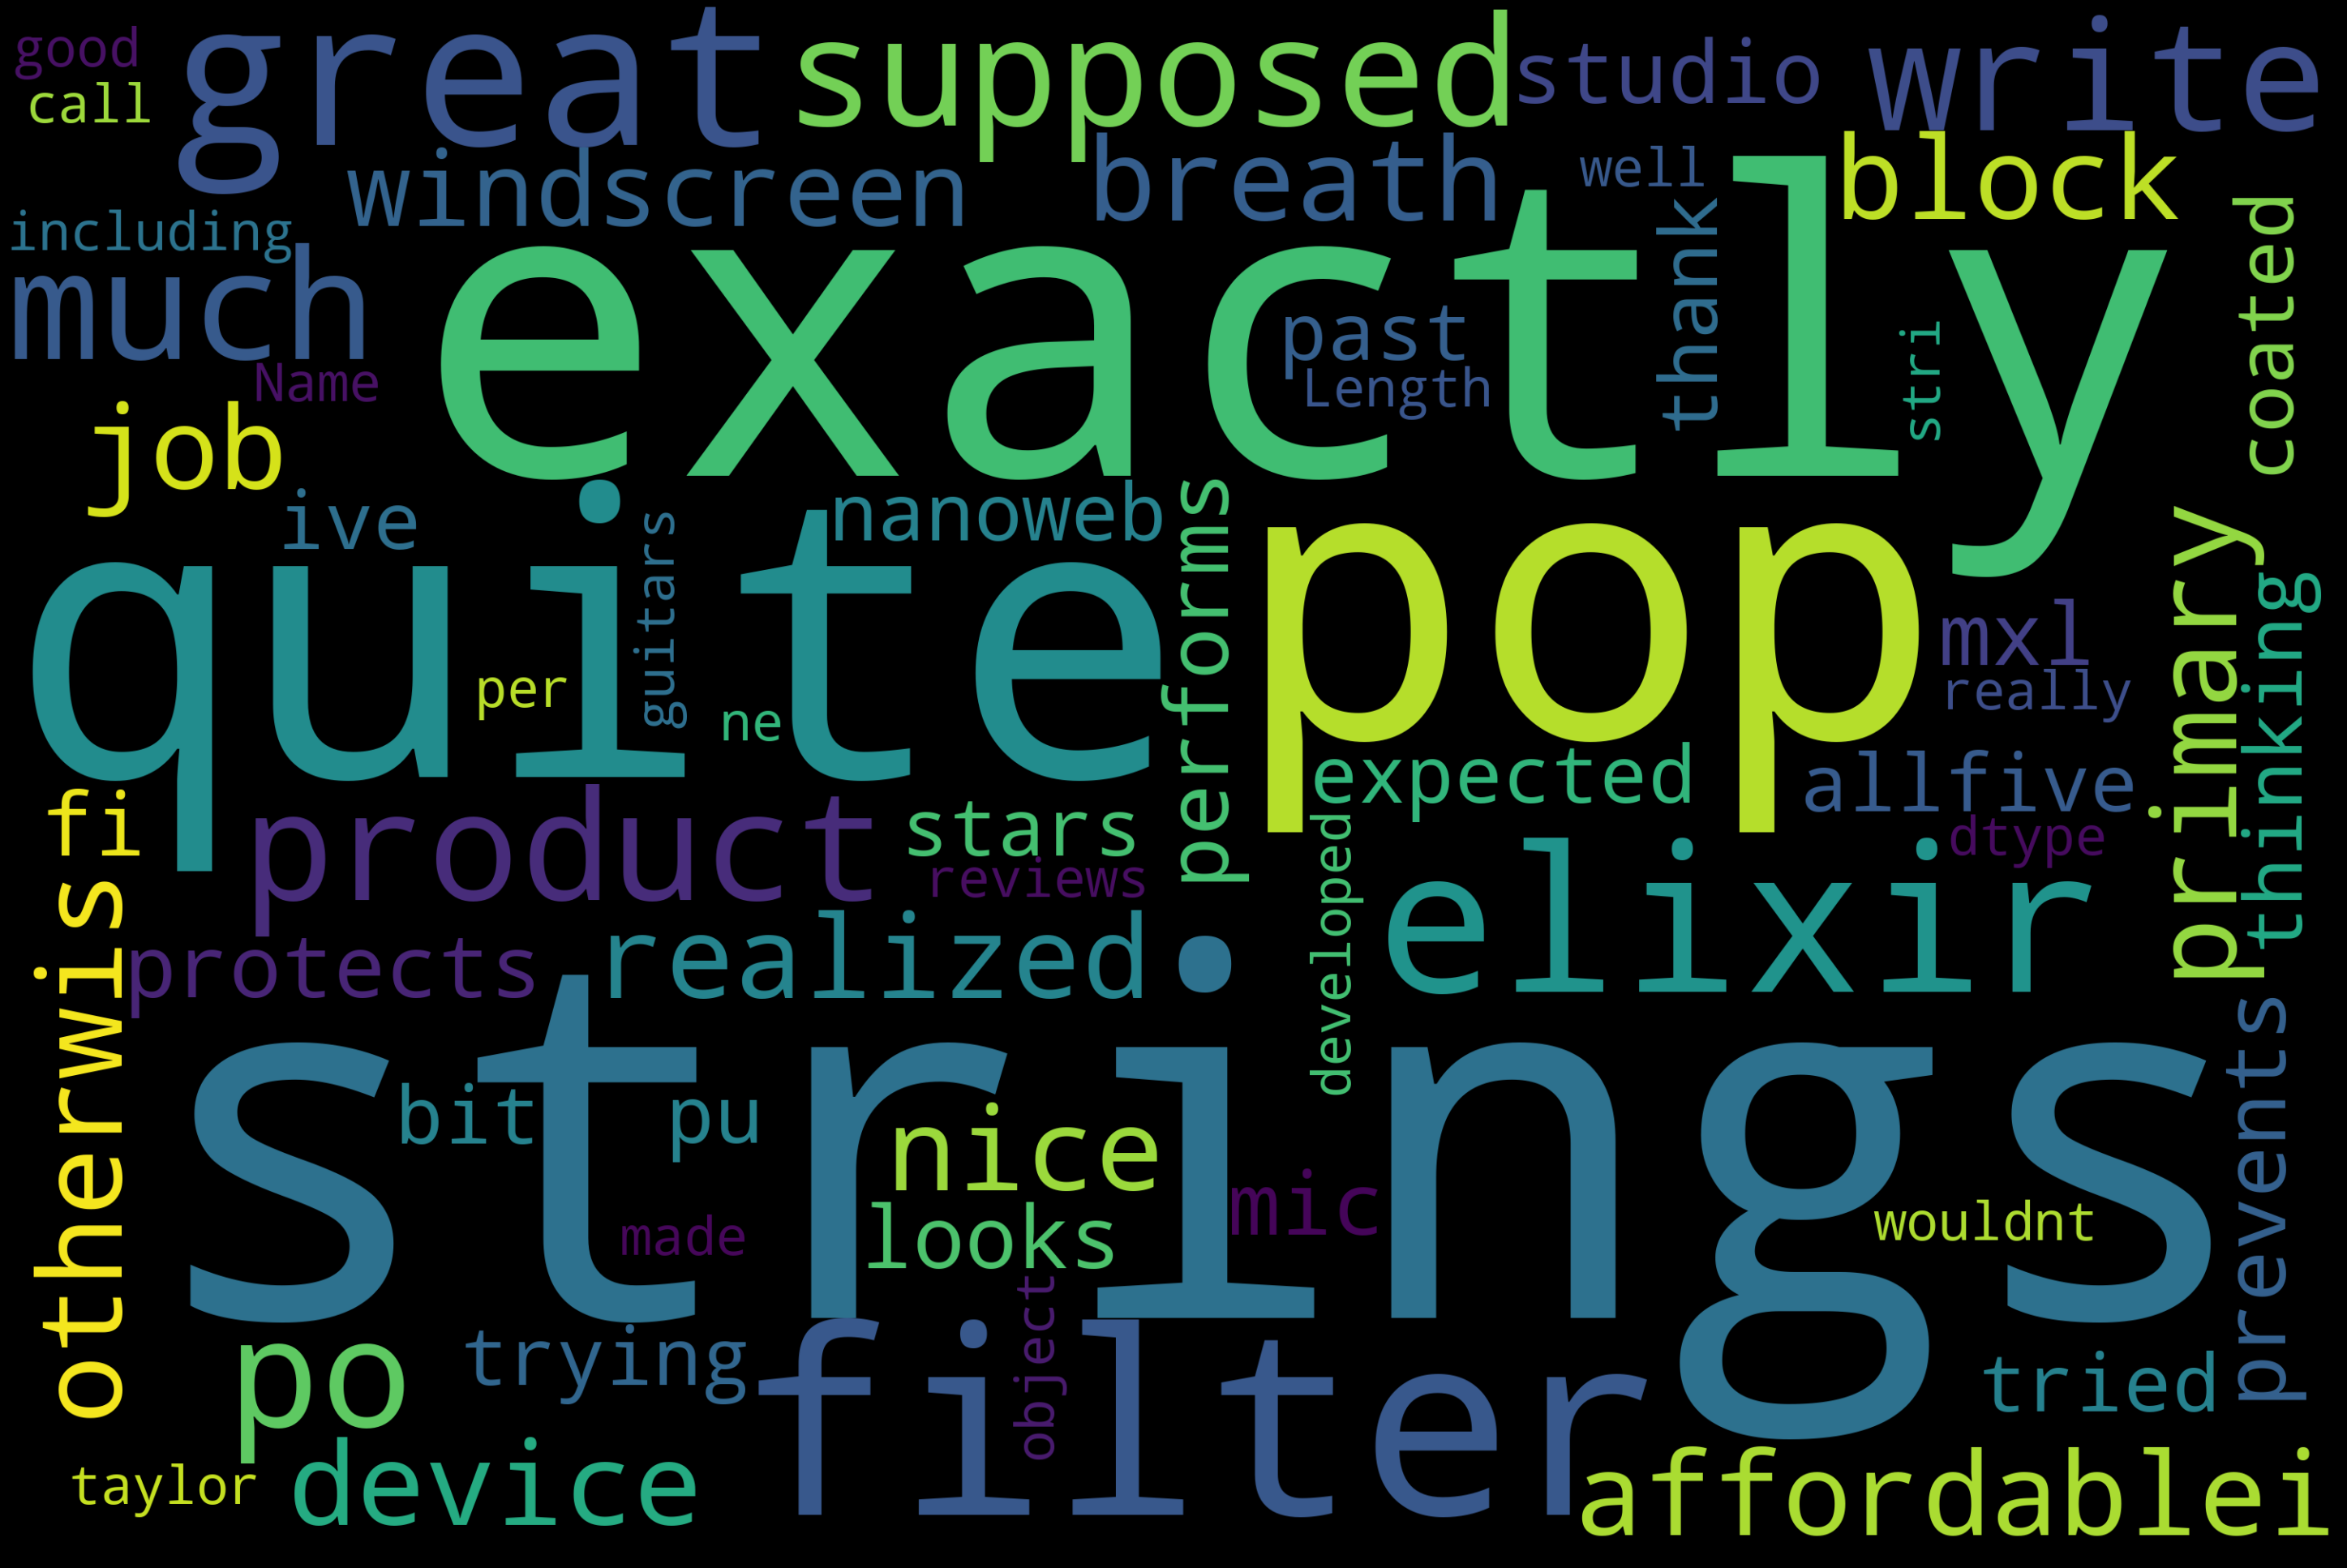

In [33]:
#For positive reviews
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We can see positive words like great,affordable,expected,exactly etc

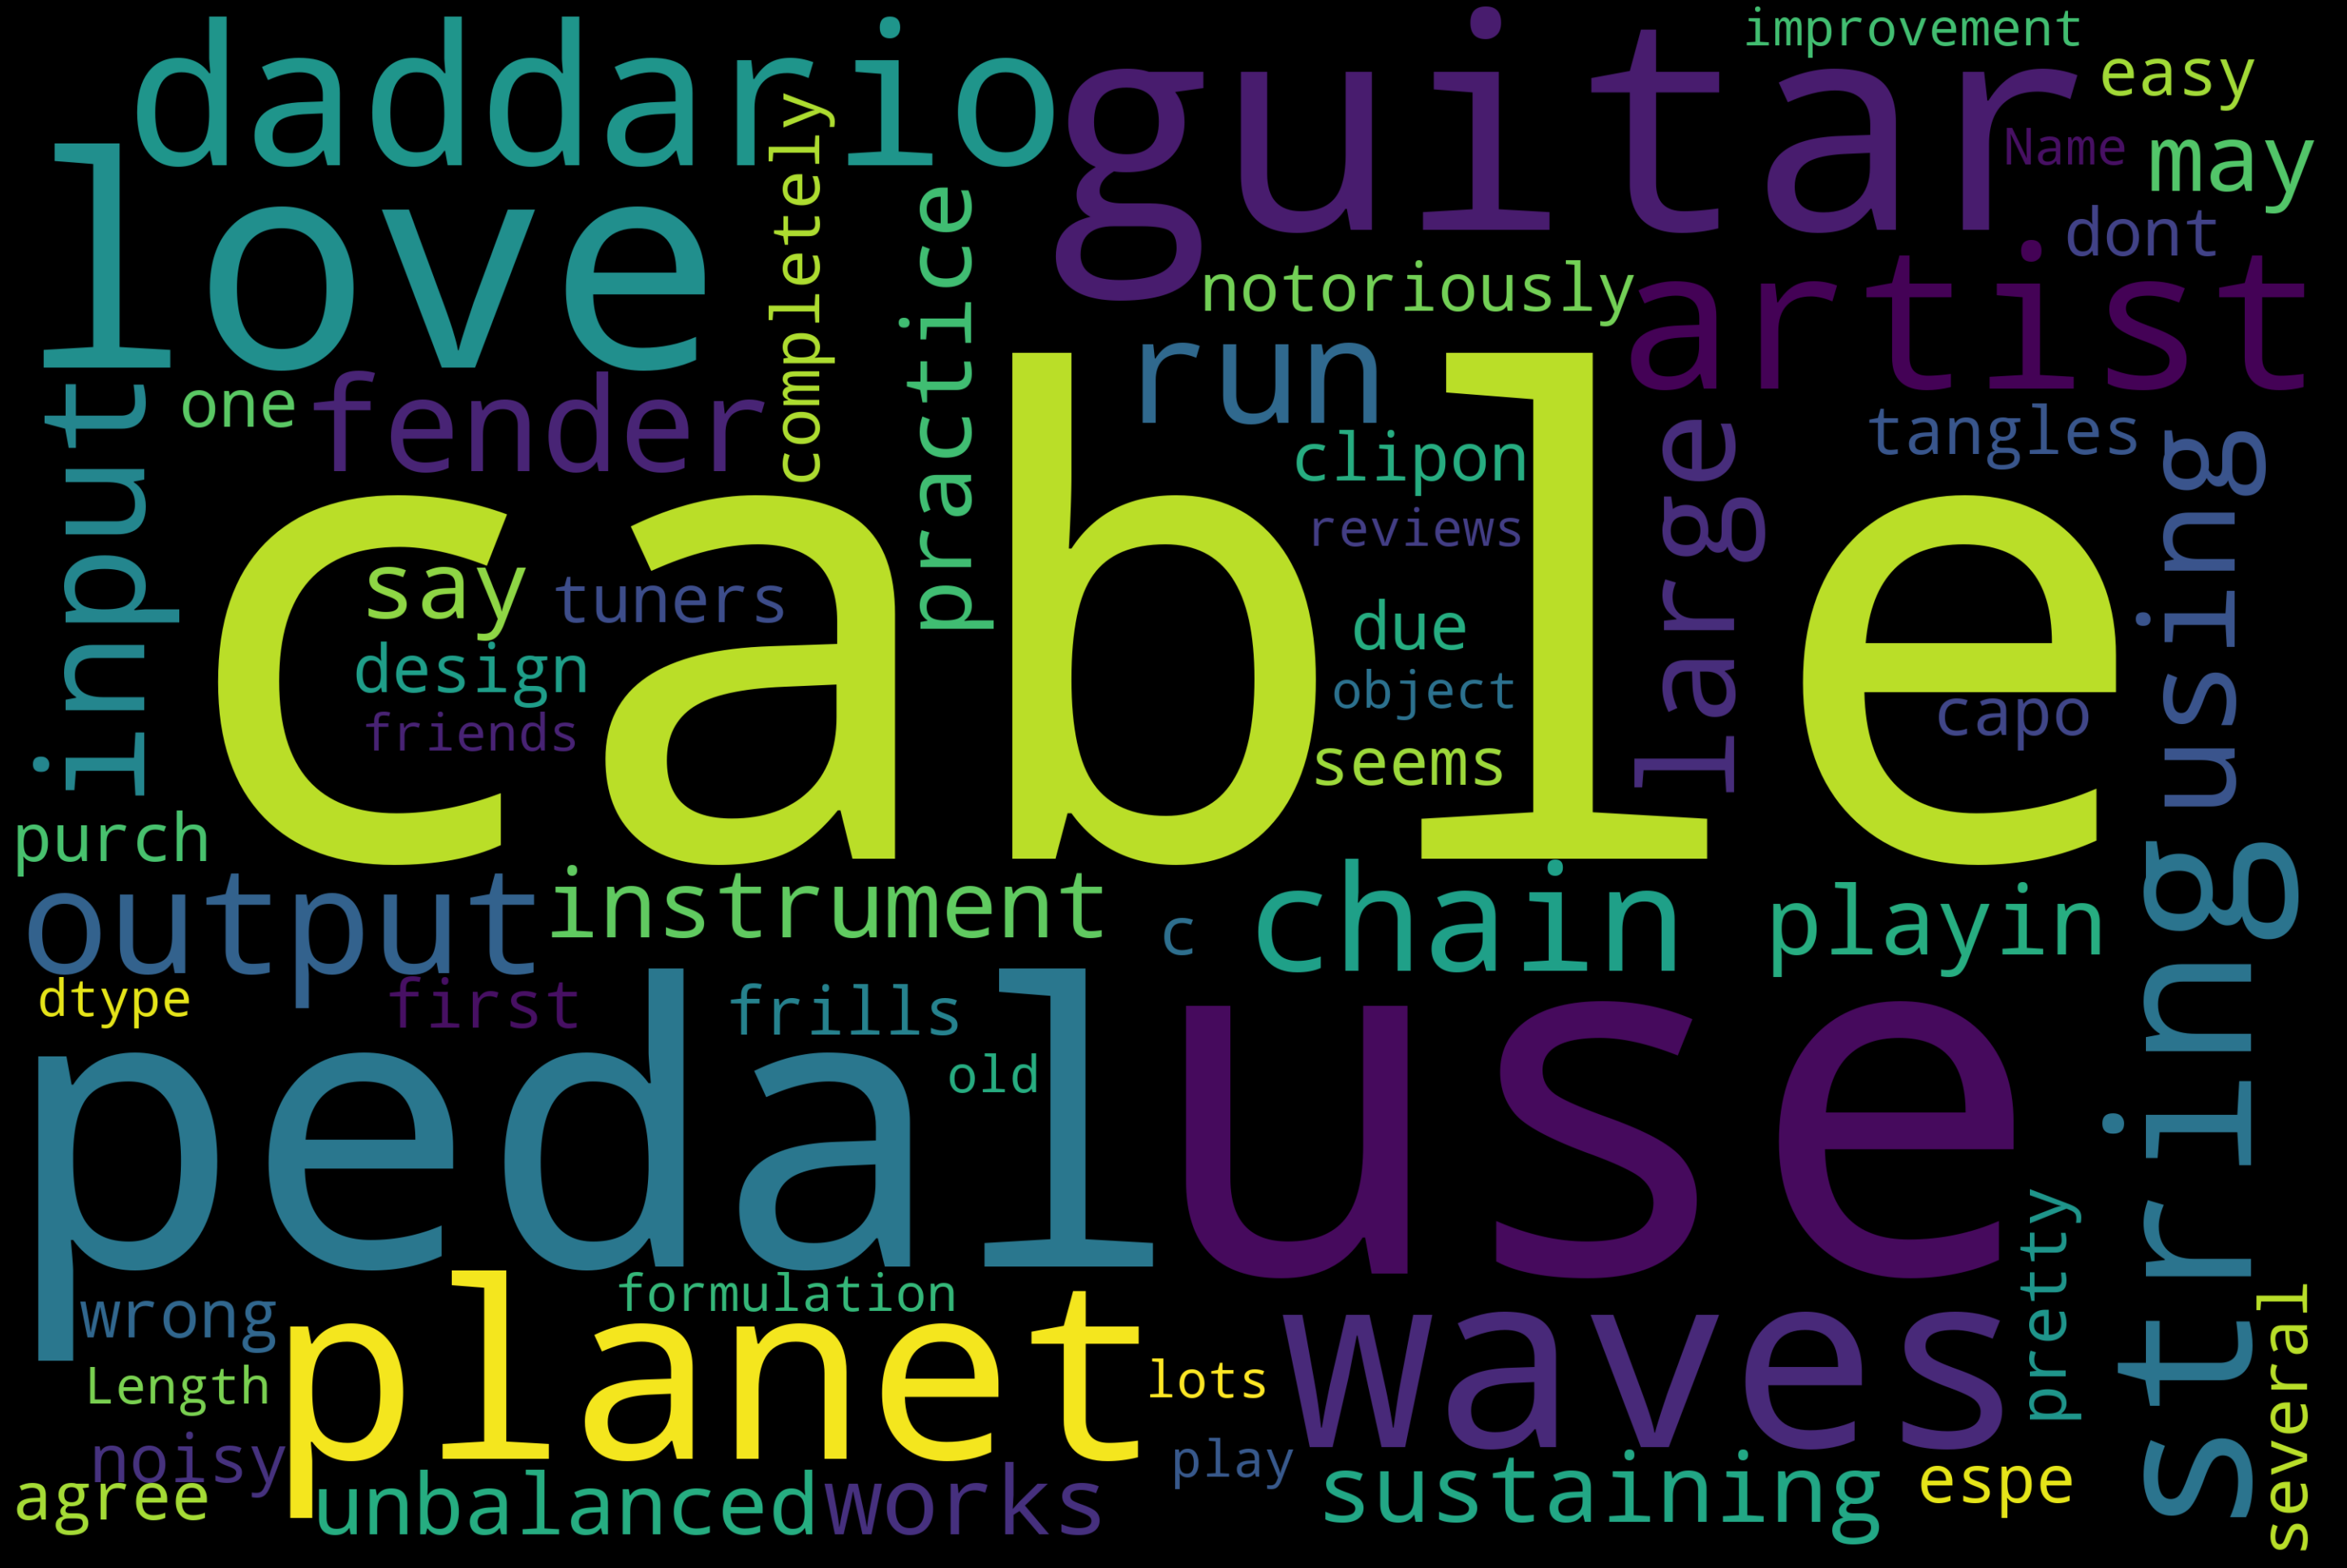

In [34]:
#For Neutral reviews
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Most of the neutral review words are focussed on the products and how can they be improved

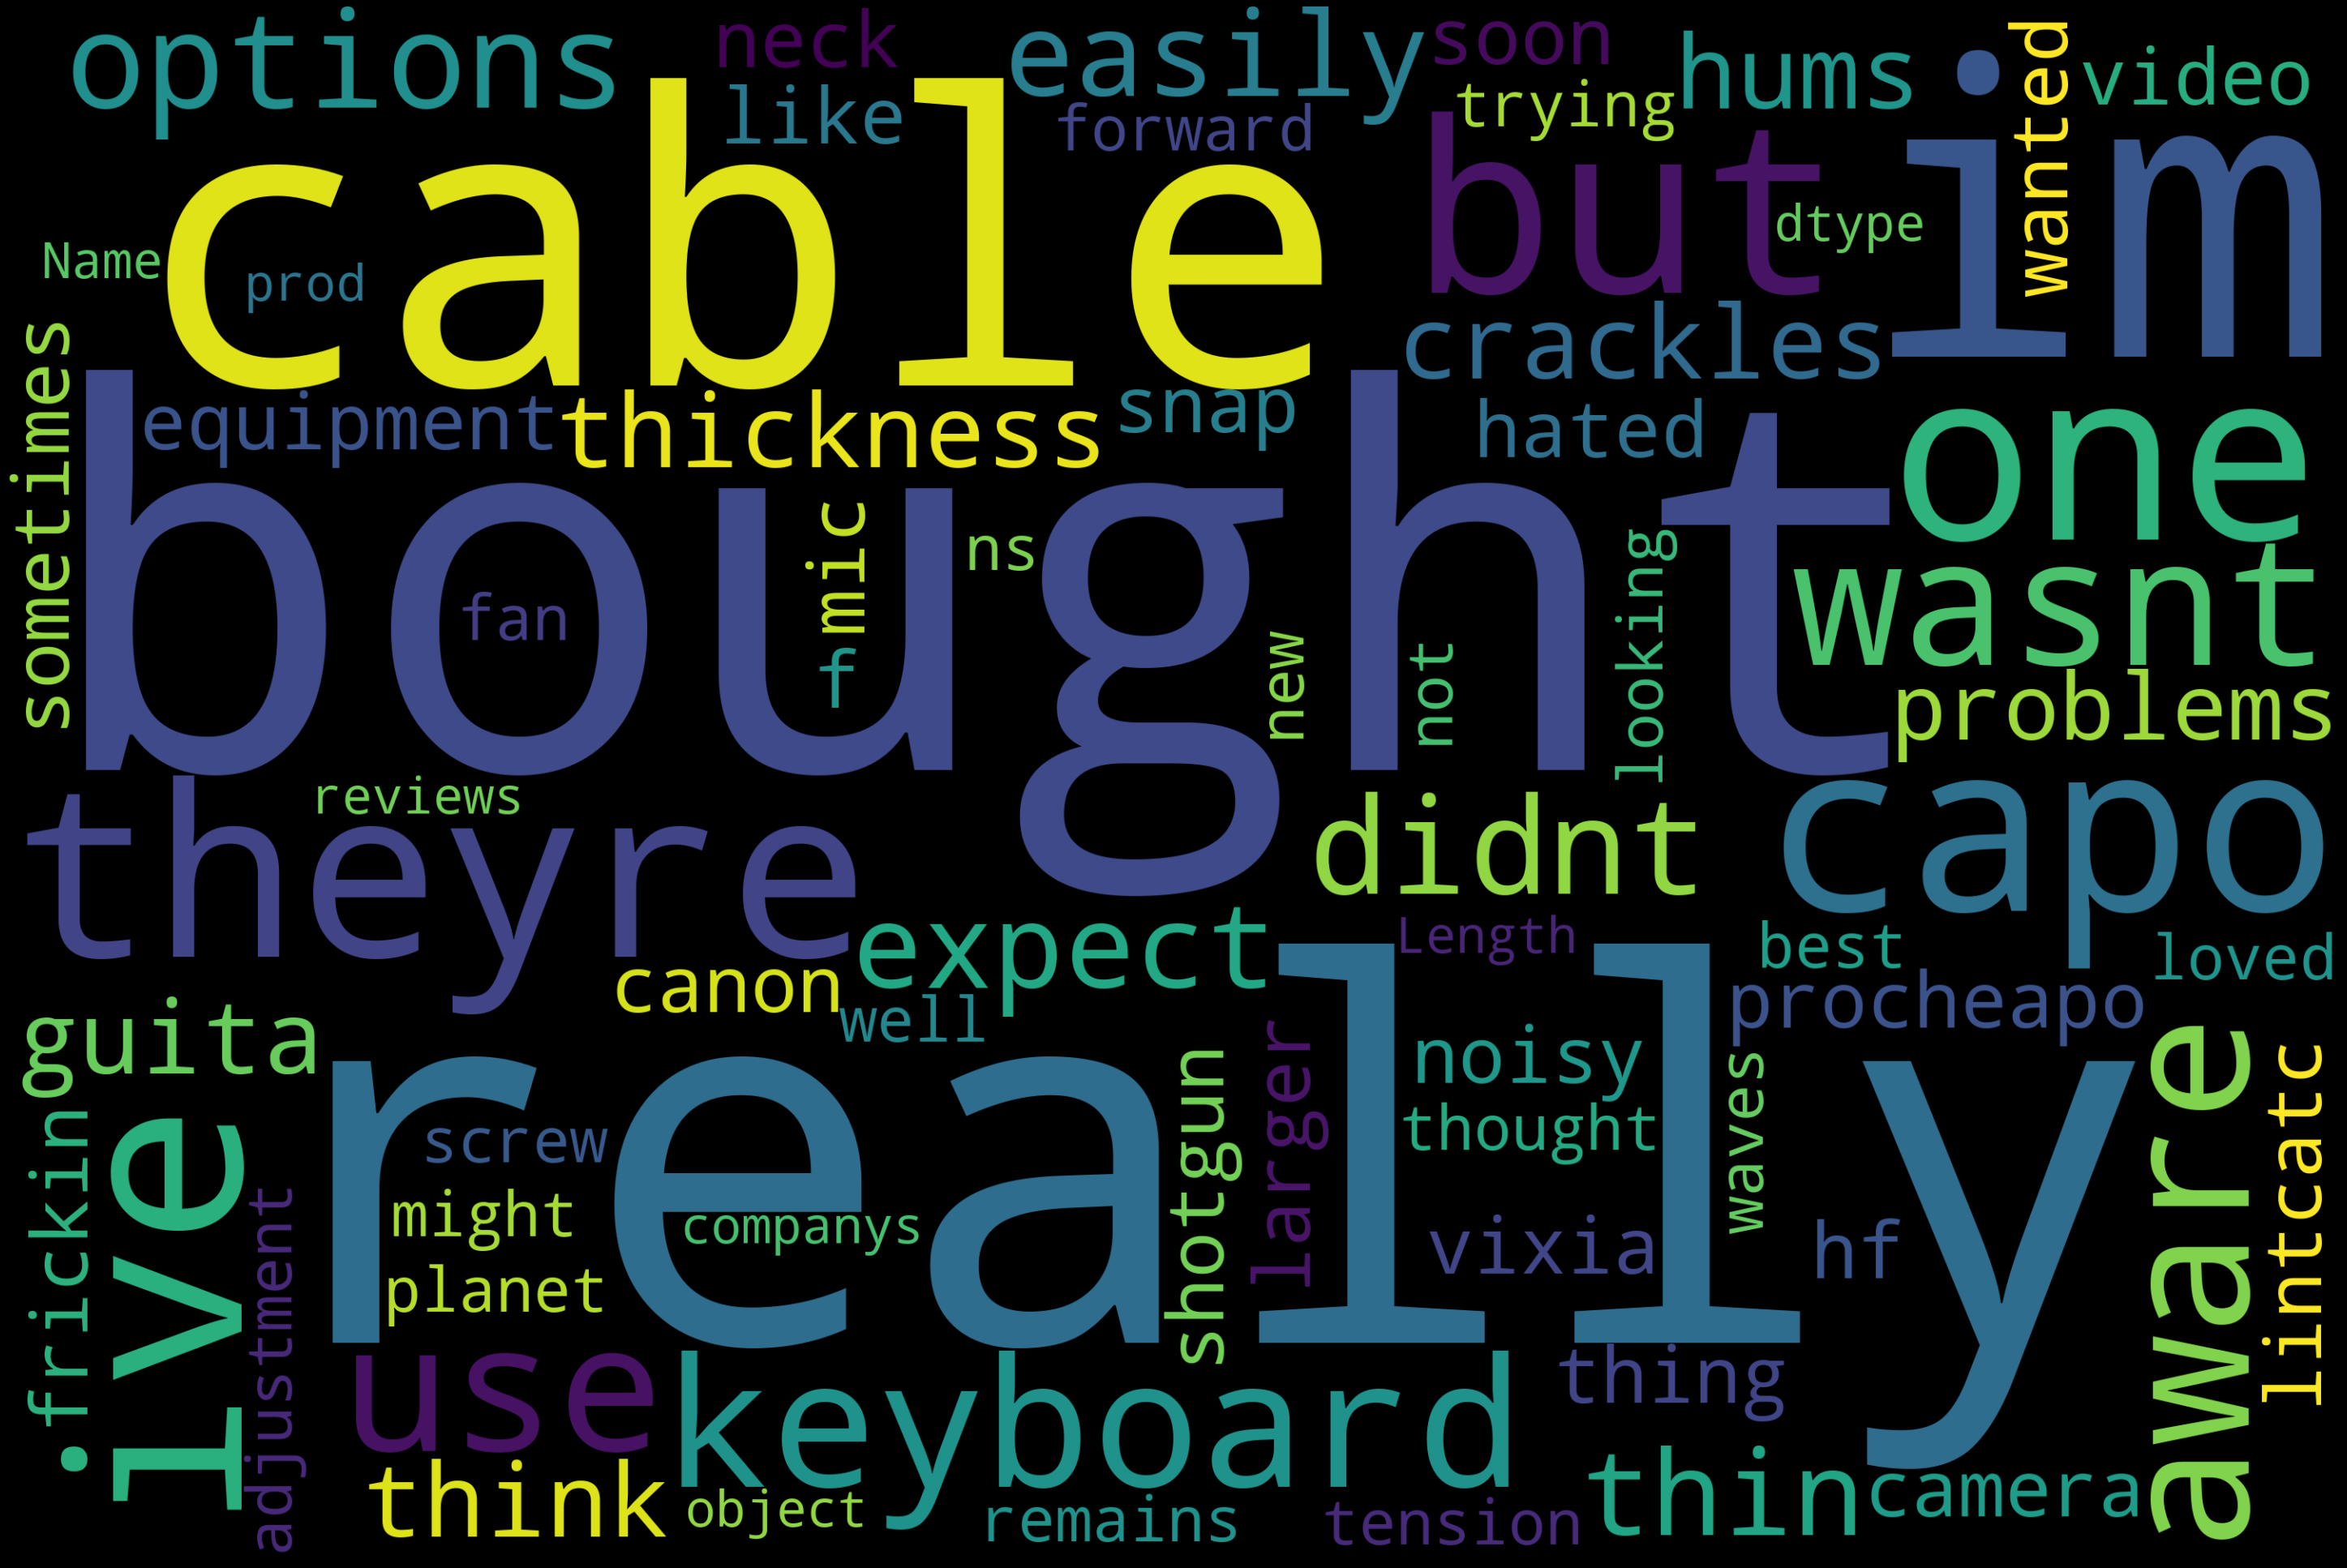

In [35]:
#Negative reviews
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We can see negative review words such as noisy,didnt,frickin,wasnt,snap,problems,tension etc

**Extracting features and Vectorisation**

In [36]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique()

array([2, 1, 0])

In [37]:
process_reviews['sentiment'].value_counts()

2    9015
1     772
0     467
Name: sentiment, dtype: int64

In [38]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  not much write but exactly supposed filters po...
1  product exactly quite affordablei not realized...
2  primary job device block breath would otherwis...
3  nice windscreen protects mxl mic prevents pops...
4  pop filter great looks performs like studio fi...

In [39]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)  

In [40]:
corpus[3]

'nice windscreen protect mxl mic prevent pop thing gooseneck margin abl hold screen posit requir care posit clamp avoid sagginggood windscreen money'

In [41]:
#Tf-Idf vectorisation
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [42]:
X.shape

(10254, 5000)

In [43]:
#Getting the target variable(encoded)
y=process_reviews['sentiment']

**SMOTE TECHNIQUE FOR IMBALANCED DATASET PROBLEM**

In [44]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 9015, 1: 772, 0: 467})
Resampled dataset shape Counter({2: 9015, 1: 9015, 0: 9015})


**Train Test Split**

In [45]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

In [46]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8805345885037799
Decision Tree Test Accuracy: 0.8145131935529882
KNN Test Accuracy: 0.8714643655208482
SVC Test Accuracy: 0.8793643322398136
Naive Bayes Test Accuracy: 0.8026064755384397


From the results, we can see logistic regression outdone the rest of the algorithms and all the accuracies from the results are more than 80%. That's great. So let's go with logistic regression with hyperparameter tuning.

**Logistic Regression with Hyperparameter tuning**

In [47]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=10000.0, random_state=0)
The mean accuracy of the model is: 0.9396628216503993


In [48]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


In [49]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      2302
           1       0.91      0.98      0.94      2246
           2       1.00      0.84      0.91      2214

    accuracy                           0.94      6762
   macro avg       0.94      0.94      0.94      6762
weighted avg       0.94      0.94      0.94      6762



We got a pretty good f1 score. As we see it got a good score across all classes classified